In [45]:
import numpy as np
import pandas as pd
import copy
from itertools import compress

In [46]:
class SMO:
    def __init__(self,x,y,C,alpha,kernel,b=1,error=[],histalp=[]):
        self.x = x.values
        self.y = y.values
        self.C = C
        self.alpha = np.resize(alpha,(len(alpha),1))
        self.kernel = kernel
        self.b = b
        self.error = error
        self.histalp = histalp

In [47]:
linear_kernel = lambda x,y,b=1: x @ y.T + b

In [48]:
def rbf(x,y,gamma=1/2):
    x_norm = np.sum(x ** 2, axis = -1)
    y_norm = np.sum(y ** 2, axis = -1)
    if type(x_norm) == np.ndarray and type(y_norm) == np.ndarray:
        K = np.exp(-gamma*( x_norm[:,None] + y_norm[None,:] - 2 * x @ y.T))
    elif type(y_norm) == np.ndarray:
        K = np.exp(-gamma*(x_norm + y_norm[None,:] - 2 * x @ y.T))
    else:
        K = np.exp(-gamma*(x_norm + y_norm - 2 * x @ y.T))
    return K.T

In [49]:
def objective_function(x_train,x_pred,y,alpha,kernel):
    o = np.sum(alpha) - 1/2 * np.sum(np.outer(y,y) * kernel(x_train,x_pred) \
                    * np.outer(alpha,alpha))
    return o

In [50]:
def decision_function(x_train,x_pred,y,alpha,kernel,b):
    d = (alpha * y).T @ kernel(x_train,x_pred).T - b
    return np.array(d).T

In [51]:
def take_step(i_1, i_2, model):
    if i_1 == i_2:
        return 0 , model
    
    
    x = model.x
    y = model.y

    y_1 = model.y[i_1]
    y_2 = model.y[i_2]
    C = model.C
    kernel = model.kernel
    
    alpha_1 = model.alpha[i_1]
    alpha_2 = model.alpha[i_2]
    E_1 = model.error[i_1]
    E_2 = model.error[i_2]

    s = y_1 * y_2

    if y_1 != y_2:
        L = max(0, alpha_2 - alpha_1)
        H = min(C, C + alpha_2 - alpha_1)

    elif y_1 == y_2:
        L = max(0, alpha_2 + alpha_1 - C)
        H = min(C, alpha_2 + alpha_1)

    if L == H:
        return 0, model

    k_11 = kernel(model.x[i_1],model.x[i_1])
    k_12 = kernel(model.x[i_1],model.x[i_2])
    k_22 = kernel(model.x[i_2],model.x[i_2])

    eta = 2*k_12 - k_11 - k_22

    if eta < 0:
        a_2 = alpha_2 - y_2*(E_1 - E_2)/eta
        if a_2 < L:
            a_2 = L

        elif a_2 > H:
            a_2 = H
    
    else:
        alpha_test = copy.deepcopy(model.alpha)

        alpha_test[i_2] = L
        L_obj = objective_function(x,x,y,alpha_test,kernel)

        alpha_test[i_2] = H
        H_obj = objective_function(x,x,y,alpha_test,kernel)

        if L_obj > H_obj + eps:
            a_2 = L

        elif L_obj < H_obj - eps:
            a_2 = H

        else:
            a_2 = alpha_2

    if a_2 < 1e-08:
        a_2 = 0

    elif a_2 > C - 1e-08:
        a_2 = C

    if (np.abs(a_2 - alpha_2)) < eps*(a_2 + alpha_2 + eps):
        return 0 , model
    
    a_1 = alpha_1 + s*(alpha_2 - a_2)
    b_1 = E_1 + y_1*(a_1 - alpha_1)*k_11 + y_2*(a_2 - alpha_2)*k_12 + model.b
    b_2 = E_2 + y_1*(a_1 - alpha_1)*k_12 + y_2*(a_2 - alpha_2)*k_22 + model.b

    if 0 < a_1 < C:
        b_new = b_1

    elif 0 < a_2 < C:
        b_new = b_2

    else:
        b_new = (b_1+b_2)/2

    if a_1 > 0 and a_1 < C:
        model.error[i_1] = 0

    if a_2 > 0 and a_2 < C:
        model.error[i_2] = 0

    idx = (np.arange(len(model.error))!=i_1) & (np.arange(len(model.error))!=i_2)
    model.error[idx] = ((model.error[idx]).T + np.array(y_1*(a_1 - alpha_1)*kernel(x[i_1],x[idx])).T \
                        + np.array(y_2*(a_2 - alpha_2)*kernel(x[i_2],x[idx])).T + model.b - b_new).T

    temp = copy.deepcopy(model.alpha)
    model.alpha[i_1] = a_1
    model.alpha[i_2] = a_2
    all_alpha.append(temp)
    model.b = b_new

    return 1, model


In [52]:
def examine_example(i_2,model):
    y_2 = model.y[i_2]
    alpha_2 = model.alpha[i_2]
    E_2 = model.error[i_2]
    r_2 = E_2 * y_2
    idx = (model.alpha != 0) & (model.alpha != model.C)
    

    if ((r_2 < -tol and alpha_2 < model.C) or (r_2 > tol and alpha_2 > 0)):
        if len(model.alpha[idx]) > 1:
            if E_2 <= 0:
                i_1 = np.argmax(model.error)
            
            elif E_2 > 0:
                i_1 = np.argmin(model.error)

            temp,model = take_step(i_1,i_2,model)
            if temp:
                return 1, model

        idx_shuffle = list(compress(range(len(idx)), idx))
        np.random.shuffle(idx_shuffle)

        for i in idx_shuffle:
            i_1 = i
            
            temp,model = take_step(i_1,i_2,model)
            if temp:
                return 1, model

        idx_shuffle = np.arange(len(model.alpha))
        np.random.shuffle(idx_shuffle)

        for i in idx_shuffle:
            i_1 = i
            
            temp,model = take_step(i_1,i_2,model)
            if temp:
                return 1, model


    return 0, model

            


In [53]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
# This line is only needed if you have a HiDPI display
%config InlineBackend.figure_format = 'retina'

from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [54]:
X_train, y = make_blobs(n_samples=1000, centers=2,
                        n_features=2, random_state=2)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)
y[y == 0] = -1

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
X_train, y = make_circles(n_samples=500, noise=0.2,
                          factor=0.1,
                          random_state=1)

y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.3,random_state=109)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)


Text(0, 0.5, 'x_2')

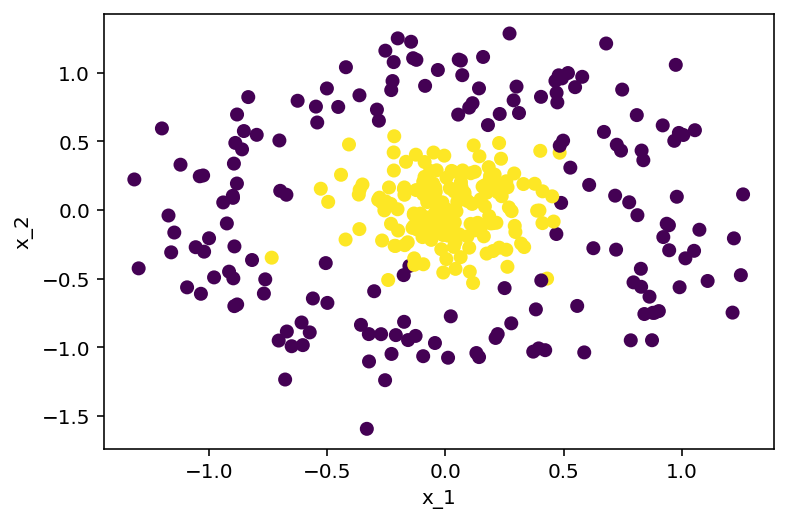

In [56]:
plt.scatter(X_train[:,0],X_train[:,1],c = y_train)
plt.xlabel('x_1')
plt.ylabel('x_2')

In [57]:
X_train_scaled = pd.DataFrame(X_train)
y = pd.DataFrame(y_train)
alpha = np.zeros(len(X_train_scaled))
model = SMO(X_train_scaled,y,1000,alpha,rbf)
Error_0 = decision_function(model.x,model.x,model.y,model.alpha,model.kernel,model.b)
model.error = Error_0 - model.y
eps = 10**-3
tol = 10**-3


In [58]:
num_changed = 0
examine_all = 1
all_obj = []
all_alpha = [model.alpha]
c=0

while ((num_changed > 0) | (examine_all)):

    idx = (model.alpha != 0) & (model.alpha != model.C)
    num_changed = 0

    if examine_all:
        for i_2 in range(len(model.x)):
            temp,model = examine_example(i_2,model)
            num_changed += temp

            if temp:
                obj = objective_function(model.x,model.x,model.y,model.alpha,model.kernel)
                all_obj.append(obj)
    
    else:
        idx_shuffle = list(compress(range(len(idx)), idx))

        
        for i_2 in idx_shuffle:
            temp,model = examine_example(i_2,model)
            num_changed += temp

            if temp:
                obj = objective_function(model.x,model.x,model.y,model.alpha,model.kernel)
                all_obj.append(obj)
    


    if examine_all == 1:
        examine_all = 0

    elif num_changed == 0:
        examine_all = 1

In [60]:
sys.getsizeof(model.kernel(model.x,model.x))

128

In [61]:
sys.getsizeof(alpha[:2])

112

In [62]:
from numpy.linalg import norm
q_convergence = []
for i in range(1,len(all_alpha)-1):
    q_convergence.append(norm(all_alpha[i] - model.alpha,1)/norm(all_alpha[i-1] - model.alpha,1))

/var/folders/cs/_3gb9qkn6rggrn50156xx4_c0000gn/T/ipykernel_37978/546784124.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  q_convergence.append(norm(all_alpha[i] - model.alpha,1)/norm(all_alpha[i-1] - model.alpha,1))


Text(0, 0.5, 'Q_convergence of 1')

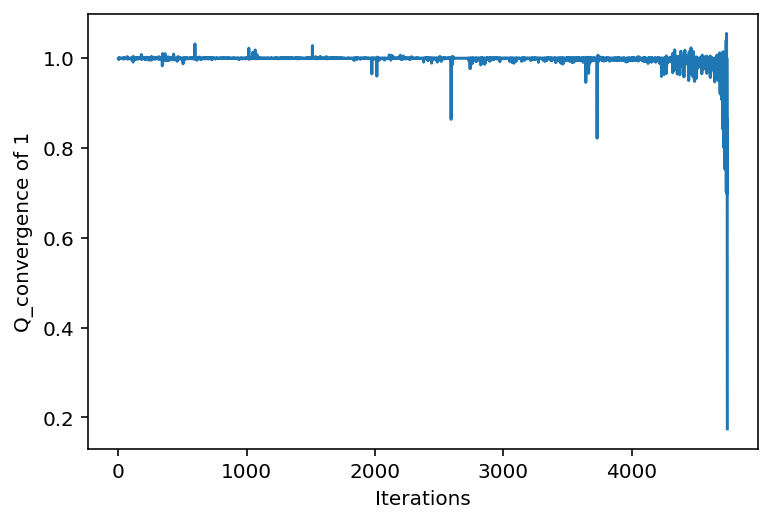

In [63]:
plt.plot(q_convergence)
plt.xlabel('Iterations')
plt.ylabel('Q_convergence of 1')

Text(0, 0.5, 'Q_convergence of 1')

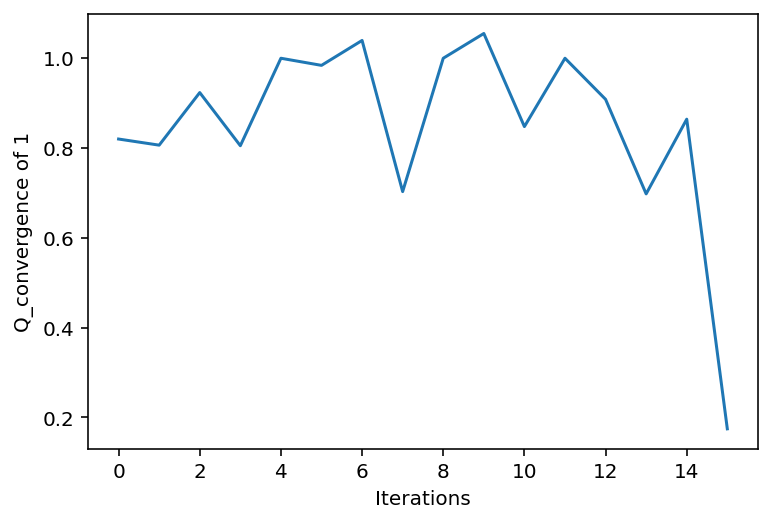

In [64]:
plt.plot(q_convergence[-16:])
plt.xlabel('Iterations')
plt.ylabel('Q_convergence of 1')

In [65]:
exp_con = []
for i in range(len(all_alpha)-1):
    exp_con.append(np.log((norm(all_alpha[i] - model.alpha))))

/var/folders/cs/_3gb9qkn6rggrn50156xx4_c0000gn/T/ipykernel_37978/4202571062.py:3: RuntimeWarning: divide by zero encountered in log
  exp_con.append(np.log((norm(all_alpha[i] - model.alpha))))


Text(0, 0.5, 'Exponential Convergence')

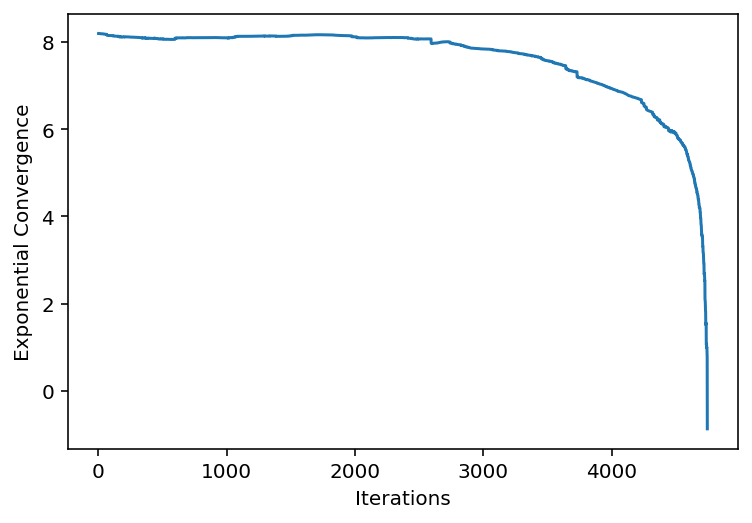

In [66]:
plt.plot(exp_con)
plt.xlabel('Iterations')
plt.ylabel('Exponential Convergence')

Text(0, 0.5, 'Exponential Convergence')

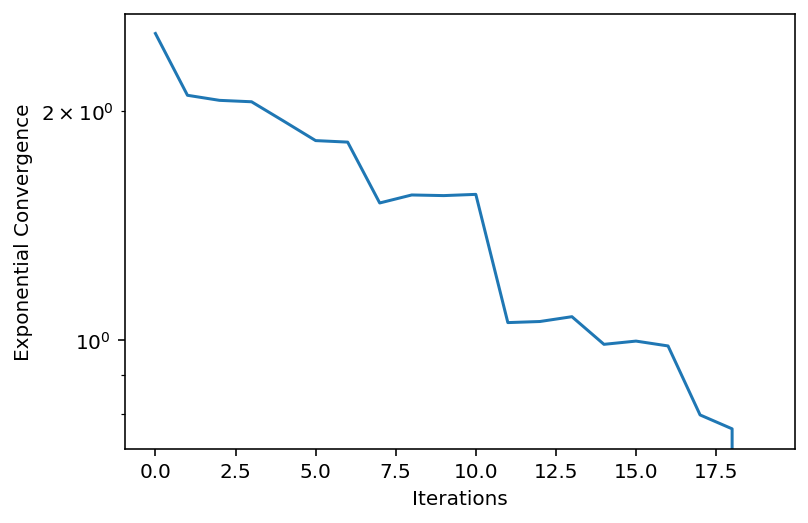

In [67]:
plt.plot(exp_con[-20:])
plt.yscale("log")
plt.xlabel('Iterations')
plt.ylabel('Exponential Convergence')


In [68]:
y_pred = np.sign(decision_function(model.x,model.x,model.y,model.alpha,model.kernel,model.b))

Text(0, 0.5, 'Objective Function')

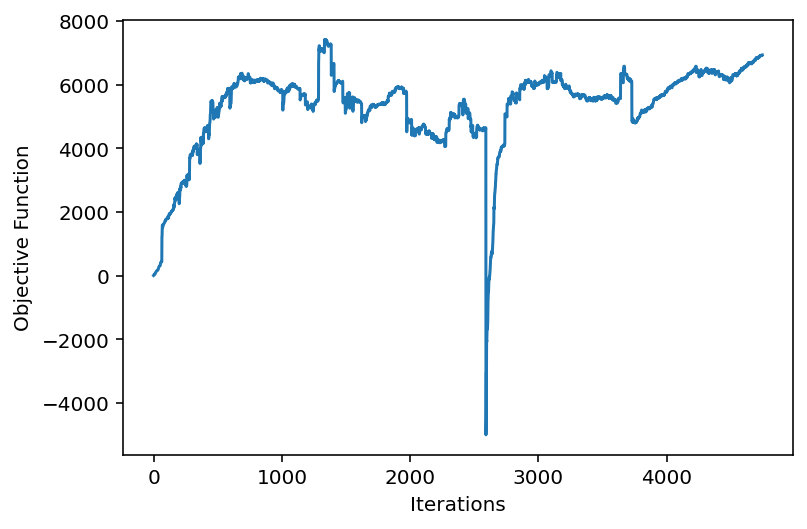

In [69]:
plt.plot(all_obj)
plt.xlabel('Iterations')
plt.ylabel('Objective Function')

In [70]:
len(model.alpha[model.alpha != 0])

20

Text(0, 0.5, 'x_2')

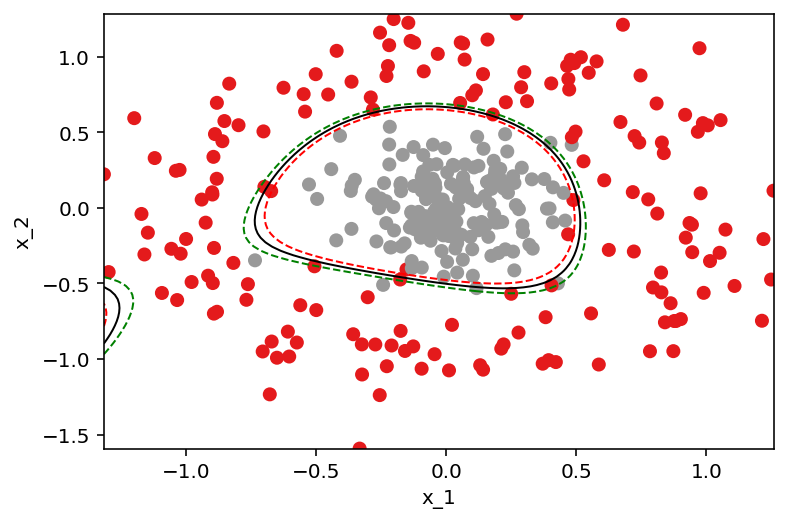

In [71]:
fig, ax = plt.subplots()
levels=(-1, 0, 1)
colors=('green', 'black', 'red')
xrange = np.linspace(model.x[:,0].min(), model.x[:,0].max(), 100)
yrange = np.linspace(model.x[:,1].min(), model.x[:,1].max(), 100)
grid = [[decision_function(model.x,np.array([xr, yr]),model.y,model.alpha,model.kernel,model.b)
                                 for xr in xrange] for yr in yrange]
grid = np.array(grid).reshape(len(xrange), len(yrange))
ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=colors)

ax.scatter(model.x[:,0], model.x[:,1],
                   c=model.y, cmap=plt.cm.Set1)

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')

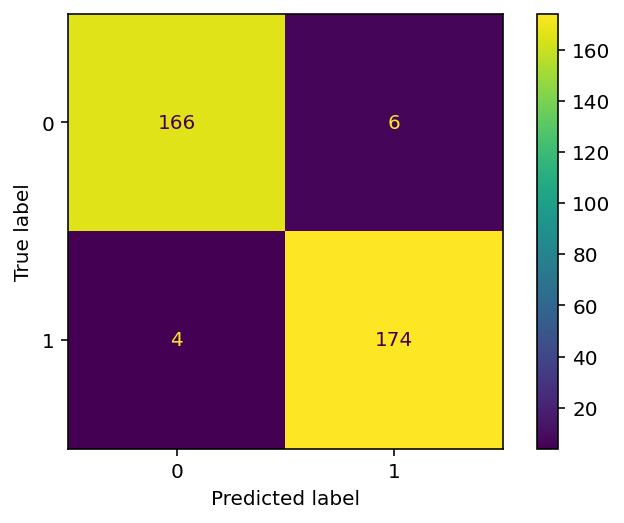

In [72]:
cm = confusion_matrix(y_pred,model.y)
ConfusionMatrixDisplay(confusion_matrix = cm).plot()

In [73]:
from sklearn.metrics import classification_report

print(classification_report(model.y, y_pred))

              precision    recall  f1-score   support

          -1       0.97      0.98      0.97       170
           1       0.98      0.97      0.97       180

    accuracy                           0.97       350
   macro avg       0.97      0.97      0.97       350
weighted avg       0.97      0.97      0.97       350



In [74]:
y_pred_test = np.sign(decision_function(model.x,X_test,model.y,model.alpha,model.kernel,model.b))

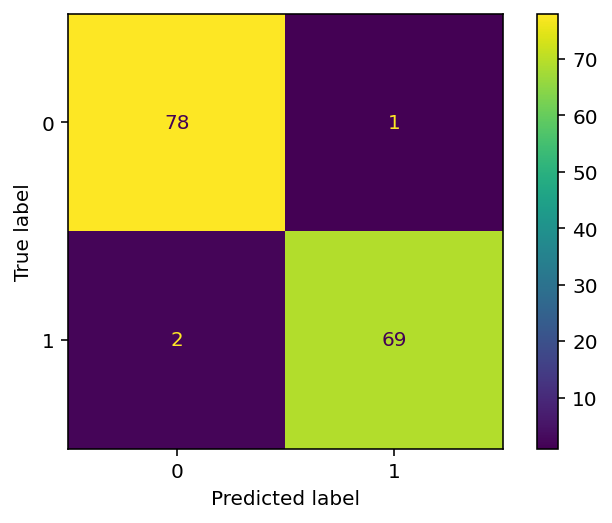

In [75]:
cm = confusion_matrix(y_pred_test,y_test)
ConfusionMatrixDisplay(confusion_matrix = cm).plot()

In [76]:
print(classification_report(y_pred_test,y_test))

              precision    recall  f1-score   support

        -1.0       0.97      0.99      0.98        79
         1.0       0.99      0.97      0.98        71

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150

